In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append('../../../module/')

from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam
import csv
import itertools
from util import *
import gym2
from rl2.agents import selfDDPGAgent, selfDDPGAgent2, selfDDPGAgent3
from rl2.memory import SequentialMemory

Using TensorFlow backend.
Using TensorFlow backend.


In [2]:
env = gym2.make('Linear-v1')
Q = .01 * np.eye(2)
R = .01

In [3]:
def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

def value_net(s_shape):
    state_input = Input((1,)+s_shape)
    x = Flatten()(state_input)
    
    x = Dense(16, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    x = Dense(1, activation="linear")(x)
    value = Model(inputs=state_input, output=x)
    return value

def branch_actor(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input) # 実質的なinput layer
    
    x1 = Dense(16, activation="relu")(x)
    x1 = Dense(16, activation="relu")(x1)
    x1 = Dense(1, activation="multiple_tanh")(x1) # action signal
    
    x2 = Dense(16, activation="relu")(x)
    x2 = Dense(16, activation="relu")(x2)
    x2 = Dense(1, activation="tau_output_large")(x2) # tau
    
    output = concatenate([x1, x2])
    actor = Model(inputs=action_input, outputs=output)
    return actor

In [4]:
# load model
actor = branch_actor((2,),(2,))
#actor.load_weights('../saved_agent/learned_self_linear1_extend_actor.h5')
actor.load_weights('../saved_agent/mb_self_extend_noisy.h5')
critic = critic_net((2,),(2,))[0]
critic.load_weights('../saved_agent/learned_self_linear1_extend_critic_l.h5')
# critic.load_weights('../saved_agent/linear_init_extend_critic_l.h5')

In [5]:
def value_function_ap(state, actor, critic):
    state = np.array(state).reshape((1,1,) + state.shape)
    action = actor.predict_on_batch(state)
    value = critic.predict_on_batch([action, state])[0][0]
    return value


def value_function(state, actor, env, step_limit=1000, n_episodes=10, alpha=0.4, beta=1., ln=1.):
    ave = 0
    for ep in range(n_episodes):
        tmp = []
        env.reset()
        env.set_state(state)
        episode_reward = 0
        acc_time = 0
        for steps in range(step_limit):
            reward = 0
            x = env.state
            a_agent, tau = actor.predict(x.reshape((1,1,) + x.shape))[0]
            action_repetition = int(np.ceil(100 * tau))  # minimum natural number which makes `dt` smaller than 0.005
            dt = .01
            #action_repetition = int(np.ceil(20 * tau))  # minimum natural number which makes `dt` smaller than 0.005
            #dt = tau / action_repetition
            for p in range(action_repetition):
                _,r,_,_ = env.step(np.array([a_agent]), dt, tau, ln)
                r *= np.exp(- alpha * dt * p)
                reward += r
            reward *= dt
            reward -= beta # step reward

            episode_reward += np.exp(- alpha * acc_time) * reward
            tmp.append(episode_reward)
            acc_time += tau
        ave += episode_reward
    ave = ave / n_episodes
    return episode_reward, tmp

# 1ステップのインタラクション
def interaction(state, u, tau, env, ln=0):
    env.reset()
    x = np.array(state)
    env.set_state(x)
    reward = 0
    a_agent, tau = u, tau
    tau = np.clip(tau, 0.01, 10.)
    action_repetition = int(np.ceil(100 * tau))  # minimum natural number which makes `dt` smaller than 0.005
    dt = .01
    for p in range(action_repetition):
        _,r,_,_ = env.step(np.array([a_agent]), dt, tau, ln)
        r *= np.exp(- alpha * p * dt)
        reward += r
    reward *= dt
    reward -= beta
    state1 = env.state
    return reward, state1

def Q_function(state, action, env):
    u, tau = action
    r, next_state = interaction(state, u, tau, env)
    
    next_value = value_function(next_state, actor, env, step_limit=200, n_episodes=1, ln=0)[0]
    return r + np.exp(- alpha * tau) * next_value
    

def td_error(experience, actor, critic, mode):
    """Value function の TD (Q 関数のベルマン方程式ではない)"""
    state0, action, reward, state1 = experience
    if mode == 'true':
        v0, _ = value_function(state0, actor, env, step_limit=200, n_episodes=1, ln=0)
        discount = np.exp(- alpha * action[1])
        v1, _ = value_function(state1, actor, env, step_limit=200, n_episodes=1, ln=0)
        td = (v0 - (reward + discount * v1))**2
    elif mode == 'pred':
        v0 = critic.predict_on_batch([action.reshape(1,2), state0.reshape(1,1,2)])[0][0]
        discount = np.exp(- alpha * action[1])
        next_action = actor.predict_on_batch(state0.reshape(1,1,2))[0]
        v1 = critic.predict_on_batch([next_action.reshape(1,2), state1.reshape(1,1,2)])[0][0]
        td = (v0 - (reward + discount * v1))**2
    else:
        assert 1, 'argument `mode` should be `true` or `pred`.'
    return td

def td_error_for_q(experience, actor, critic, mode):
    state0, action, reward, state1 = experience
    if mode == 'true':
        v0 = Q_function(state0, action, env)
        discount = np.exp(- alpha * action[1])
        v1, _ = value_function(state1, actor, env, step_limit=200, n_episodes=1, ln=0)
        td = (v0 - (reward + discount * v1))**2
    elif mode == 'pred':
        v0 = critic.predict_on_batch([action.reshape(1,2), state0.reshape(1,1,2)])[0][0]
        discount = np.exp(- alpha * action[1])
        next_action = actor.predict_on_batch(state1.reshape(1,1,2))[0]
        v1 = critic.predict_on_batch([next_action.reshape(1,2), state1.reshape(1,1,2)])[0][0]
        td = (v0 - (reward + discount * v1))**2
    else:
        assert 1, 'argument `mode` should be `true` or `pred`.'
    return td

# Q関数でもV(s)の学習みたいに'TDが小'='関数として一致'が言えるか

In [14]:
alpha = 0.4
beta = 1.

memory = []
S1 = np.linspace(-7, 7, 20)
S2 = np.linspace(-7, 7, 20)
S1, S2 = np.meshgrid(S1, S2)
S1, S2 = S1.flatten(), S2.flatten()

nn = 10
for st in range(nn):
    for i, x in enumerate(zip(S1, S2)):
        env.reset()
        x = np.array(x)
        env.set_state(x)
        reward = 0
        state0 = env.state
        noise = np.array([np.random.randn(), np.random.randn() / 10.])
        a_agent, tau = actor.predict_on_batch(state0.reshape((1,1,)+state0.shape))[0] + noise
        tau = np.clip(tau, 0.01, 10.)
        action_repetition = int(np.ceil(100 * tau))  # minimum natural number which makes `dt` smaller than 0.005
        dt = .01
        for p in range(action_repetition):
            _,r,_,_ = env.step(np.array([a_agent]), dt, tau, 0)
            r *= np.exp(- alpha * p * dt)
            reward += r
        reward *= dt
        reward -= beta
        state1 = env.state
        memory.append([state0, np.array([a_agent, tau]), reward, state1])
    print('\r' + f'{int(st)*100/len(nn)} %', end='')
memory = np.array(memory)

TypeError: object of type 'int' has no len()

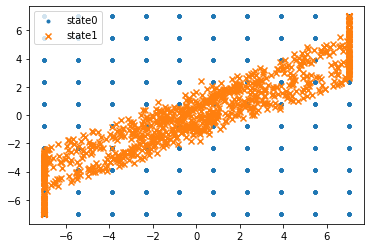

In [7]:
action_memory = np.array(memory[:,1].tolist())
state0_memory = np.array(memory[:,0].tolist())
state1_memory = np.array(memory[:,3].tolist())
plt.scatter(state0_memory[:,0], state0_memory[:,1], marker='.', label='state0')
plt.scatter(state1_memory[:,0], state1_memory[:,1], marker='x', label='state1')
plt.legend()
plt.show()

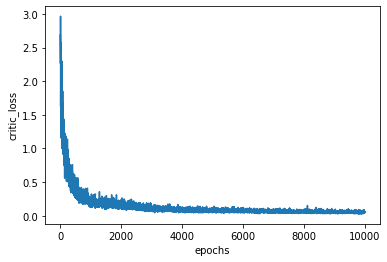

In [9]:
# critic learning
#critic = critic_net((2,),(2,))[0]
critic.compile(Adam(lr=0.001, clipnorm=1.), loss='mean_squared_error')
epoch = 10000
batch_size = 64
arr = np.array(range(memory.shape[0]))
losses = []
for _ in range(epoch):
    # make mini_batch
    mem = memory[np.random.choice(arr, batch_size, replace=False)]
    state0_batch = []
    action_batch = []
    reward_batch = []
    state1_batch = []
    for m in mem:
        state0_batch.append([m[0]])
        action_batch.append(m[1])
        reward_batch.append([m[2]])
        state1_batch.append([m[3]])
    state0_batch, action_batch, reward_batch, state1_batch = \
    np.array(state0_batch), np.array(action_batch), np.array(reward_batch), np.array(state1_batch)

    # TD error
    next_action = actor.predict_on_batch(state1_batch)
    state1_batch_with_action = [next_action, state1_batch]
    target = critic.predict_on_batch(state1_batch_with_action)
    discount = np.exp(- alpha * action_batch[:,1].reshape(batch_size, 1))
    r_second = np.multiply(discount, target)
    r = reward_batch + r_second
    
    # learn
    critic_input_batch = [action_batch, state0_batch]
    loss = critic.train_on_batch(critic_input_batch, r)
    losses.append(loss)
    
plt.plot(losses)
plt.xlabel('epochs')
plt.ylabel('critic_loss')
plt.show()

In [13]:
critic.save_weights('../saved_agent/mb_self_extend_noisy_critic.h5')

In [10]:
m = memory[np.random.choice(range(len(memory)))]
print(m)

[array([-7.,  7.]) array([-1.51773252,  0.67270312]) -2.582346415771749
 array([-5.49734584, -3.31056168])]


In [11]:
tdt = td_error_for_q(m, actor, critic, 'true')
tdp = td_error_for_q(m, actor, critic, 'pred')

In [12]:
print(f'td_error of simulation(dt=0.01) base Q(s,a): {tdt}') # ほぼ0なので, 正しいsimulationなのがわかった
print(f'td_error of neural net Q(s,a): {tdp}')

td_error of simulation(dt=0.01) base Q(s,a): 0.0
td_error of neural net Q(s,a): 0.010394597731199337


In [9]:
%%time
S1 = np.linspace(-7, 7, 20)
S2 = np.linspace(-7, 7, 20)
S1, S2 = np.meshgrid(S1, S2)
S1, S2 = S1.flatten(), S2.flatten()

#vts, vps = [], []
vps = []

for i, x in enumerate(zip(S1, S2)):
    state = np.array(x)
    #vts.append(value_function(state, actor, env, step_limit=200, n_episodes=1, ln=0)[0])
    action = actor.predict_on_batch(state.reshape(1,1,2))[0]
    vps.append(critic.predict_on_batch([action.reshape(1,2), state.reshape(1,1,2)])[0][0])
    print('\r' + f'{int(i*100/len(S1))} %', end='')

#vts = np.array(vts) # linear_vts_learned.csv
vps = np.array(vps) # linear_vps_learned.csv

99 %CPU times: user 731 ms, sys: 370 ms, total: 1.1 s
Wall time: 1.54 s


In [12]:
with open('../csv/linear_vts_learned.csv','r') as f:
    reader = csv.reader(f)
    vts = np.array([r for r in reader]).astype('float')
    
with open('../csv/linear_vps_learned.csv','r') as f:
    reader = csv.reader(f)
    vps = np.array([r for r in reader]).astype('float')

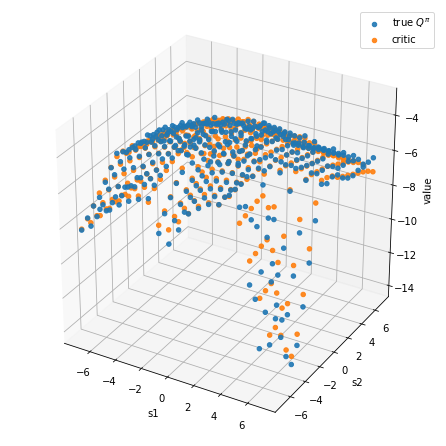

In [17]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.set_xlabel('s1')
ax.set_ylabel('s2')
ax.set_zlabel('value')

ax.scatter3D(S1.reshape(20,20), S2.reshape(20,20), vts, alpha=0.9, label='true $Q^{\pi}$')
ax.scatter3D(S1.reshape(20,20), S2.reshape(20,20), vps, alpha=0.9, label='critic')
plt.legend()

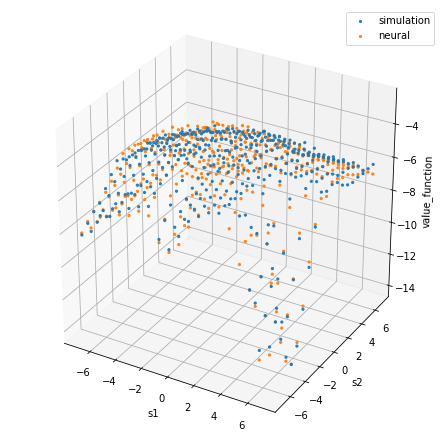

In [304]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.set_xlabel('s1')
ax.set_ylabel('s2')
ax.set_zlabel('value_function')

ax.scatter3D(S1.reshape(20,20), S2.reshape(20,20), vts, marker='.', alpha=0.9, label='simulation')
ax.scatter3D(S1.reshape(20,20), S2.reshape(20,20), vps, marker='.', alpha=0.9, label='neural')
plt.legend()

# $Q(s,\pi(s))$じゃなくて$Q(s,\pi(s)+\delta)$は合ってる？
勾配があってるのか調べれる

In [ ]:
# tau の偏微分

In [213]:
%%time
vps_delta_plus_t2 = []#, vts_delta_plus_t = [], []
delta_tau = 0.01
S1 = np.linspace(-7, 7, 20)
S2 = np.linspace(-7, 7, 20)
S1, S2 = np.meshgrid(S1, S2)
S1, S2 = S1.flatten(), S2.flatten()

for i, x in enumerate(zip(S1, S2)):
    state = np.array(x)
    action = actor.predict_on_batch(state.reshape(1,1,2))[0]
    action_plus = action + [0, delta_tau]
    action_plus = action_plus.clip(min=np.array([-10.,0.01]), max=np.array([10.,10.]))
    #vts_delta_plus_t.append(Q_function(state, action_plus, env))
    vps_delta_plus_t2.append(critic.predict_on_batch([action_plus.reshape(1,2), state.reshape(1,1,2)])[0][0])
    print('\r' + f'{int(i*100/len(S1))} %', end='')

#vts_delta_plus_t = np.array(vts_delta_plus_t)
vps_delta_plus_t2 = np.array(vps_delta_plus_t2)

99 %CPU times: user 653 ms, sys: 99.3 ms, total: 753 ms
Wall time: 588 ms


In [214]:
%%time
vps_delta_minus_t2=[]#, vts_delta_minus_t = [], []
S1 = np.linspace(-7, 7, 20)
S2 = np.linspace(-7, 7, 20)
S1, S2 = np.meshgrid(S1, S2)
S1, S2 = S1.flatten(), S2.flatten()

for i, x in enumerate(zip(S1, S2)):
    state = np.array(x)
    action = actor.predict_on_batch(state.reshape(1,1,2))[0]
    action_minus = action - [0, delta_tau]
    action_minus = action_minus.clip(min=np.array([-10.,0.01]), max=np.array([10.,10.]))
    #vts_delta_minus_t.append(Q_function(state, action_minus, env))
    vps_delta_minus_t2.append(critic.predict_on_batch([action_minus.reshape(1,2), state.reshape(1,1,2)])[0][0])
    print('\r' + f'{int(i*100/len(S1))} %', end='')

#vts_delta_minus_t = np.array(vts_delta_minus_t)
vps_delta_minus_t2 = np.array(vps_delta_minus_t2)

99 %CPU times: user 649 ms, sys: 96.7 ms, total: 746 ms
Wall time: 617 ms


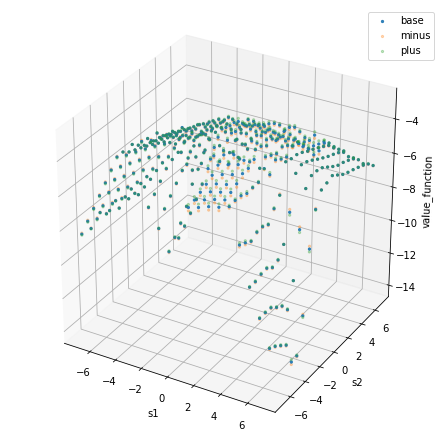

In [135]:
# neural

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.set_xlabel('s1')
ax.set_ylabel('s2')
ax.set_zlabel('value_function')

ax.scatter3D(S1.reshape(20,20), S2.reshape(20,20), vps.reshape(20,20), marker='.', alpha=0.9, label='base')
ax.scatter3D(S1.reshape(20,20), S2.reshape(20,20), vps_delta_minus.reshape(20,20), marker='.', alpha=0.3, label='minus')
ax.scatter3D(S1.reshape(20,20), S2.reshape(20,20), vps_delta_plus.reshape(20,20), marker='.', alpha=0.3, label='plus')
plt.legend()

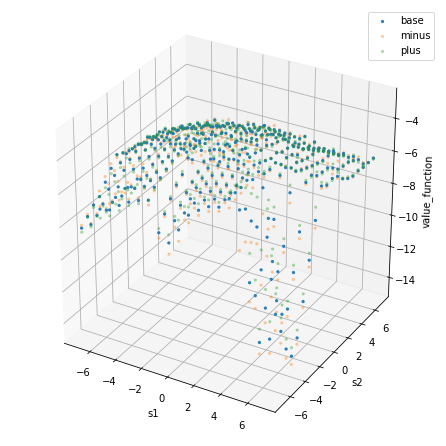

In [136]:
# simulation

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.set_xlabel('s1')
ax.set_ylabel('s2')
ax.set_zlabel('value_function')

ax.scatter3D(S1.reshape(20,20), S2.reshape(20,20), vts.reshape(20,20), marker='.', alpha=0.9, label='base')
ax.scatter3D(S1.reshape(20,20), S2.reshape(20,20), vts_delta_minus.reshape(20,20), marker='.', alpha=0.3, label='minus')
ax.scatter3D(S1.reshape(20,20), S2.reshape(20,20), vts_delta_plus.reshape(20,20), marker='.', alpha=0.3, label='plus')
plt.legend()

In [ ]:
# uの偏微分

In [307]:
%%time
delta_u = 0.1
vps_delta_plus_u2, vts_delta_plus_u = [], []
S1 = np.linspace(-7, 7, 20)
S2 = np.linspace(-7, 7, 20)
S1, S2 = np.meshgrid(S1, S2)
S1, S2 = S1.flatten(), S2.flatten()

for i, x in enumerate(zip(S1, S2)):
    state = np.array(x)
    action = actor.predict_on_batch(state.reshape(1,1,2))[0]
    action_plus = action + [delta_u, 0]
    action_plus = action_plus.clip(min=np.array([-10.,0.01]), max=np.array([10.,10.]))
    vts_delta_plus_u.append(Q_function(state, action_plus, env))
    vps_delta_plus_u2.append(critic.predict_on_batch([action_plus.reshape(1,2), state.reshape(1,1,2)])[0][0])
    print('\r' + f'{int(i*100/len(S1))} %', end='')

vts_delta_plus_u = np.array(vts_delta_plus_u)
vps_delta_plus_u2 = np.array(vps_delta_plus_u2)

99 %CPU times: user 12min, sys: 10.9 s, total: 12min 11s
Wall time: 12min 53s


In [216]:
%%time
vps_delta_minus_u2=[]#, vts_delta_minus_u = [], []
S1 = np.linspace(-7, 7, 20)
S2 = np.linspace(-7, 7, 20)
S1, S2 = np.meshgrid(S1, S2)
S1, S2 = S1.flatten(), S2.flatten()

for i, x in enumerate(zip(S1, S2)):
    state = np.array(x)
    action = actor.predict_on_batch(state.reshape(1,1,2))[0]
    action_minus = action - [delta_u, 0]
    action_minus = action_minus.clip(min=np.array([-10.,0.01]), max=np.array([10.,10.]))
    #vts_delta_minus_u.append(Q_function(state, action_minus, env))
    vps_delta_minus_u2.append(critic.predict_on_batch([action_minus.reshape(1,2), state.reshape(1,1,2)])[0][0])
    print('\r' + f'{int(i*100/len(S1))} %', end='')

#vts_delta_minus_u = np.array(vts_delta_minus_u)
vps_delta_minus_u2 = np.array(vps_delta_minus_u2)

99 %CPU times: user 672 ms, sys: 86.7 ms, total: 759 ms
Wall time: 631 ms


In [308]:
with open('../csv/delta_plus_u.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(vts_delta_plus_u)
    
with open('../csv/delta_minus_u.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(vts_delta_minus_u)

In [189]:
with open('../csv/delta_plus_t.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(vts_delta_plus_t)
    
with open('../csv/delta_minus_t.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(vts_delta_minus_t)

In [309]:
def g_type(m,b,p):
    if (m < b) and (b < p): # 単調増加
        return 0
    elif (m > b) and (b < p): # 下に凸
        return 1
    elif (m > b) and (b > p): # 単調現象
        return 2
    elif (m < b) and (b > p):
        return 3 # 上に凸
    else:
        assert 1

t_type_u, p_type_u = [], []
t_type_t, p_type_t = [], []
for i in range(len(vts[0])):
    mt, bt, pt = vts_delta_minus_u[i], vts[0][i], vts_delta_plus_u[i]
    t_type_u.append(g_type(mt, bt, pt))
    mp, bp, pp = vps_delta_minus_u2[i], vps[i], vps_delta_plus_u2[i]
    p_type_u.append(g_type(mp, bp, pp))
    
    mt, bt, pt = vts_delta_minus_t[i], vts[0][i], vts_delta_plus_t[i]
    t_type_t.append(g_type(mt, bt, pt))
    mp, bp, pp = vps_delta_minus_t2[i], vps[i], vps_delta_plus_t2[i]
    p_type_t.append(g_type(mp, bp, pp))

In [310]:
dif_u = np.array(p_type_u) - np.array(t_type_u)
dif_u = np.where(dif_u==0,0,1)
1 - np.mean(dif_u)

0.44999999999999996

In [301]:
dif_t = np.array(p_type_t) - np.array(t_type_t)
dif_t = np.where(dif_t==0,0,1)
1 - np.mean(dif_t)

0.4625

In [198]:
dif_t

array([0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1,